In [1]:
import pandas as pd 
import numpy as np 
import math 
import yfinance as yf 
import quantstats as qs 
from sklearn.linear_model import LinearRegression, LogisticRegression

import warnings 
warnings.filterwarnings('ignore') 

In [6]:
def linear_regression(train, test):

    #Creating columns of independent variables
    train['H-C'] = train['High'] - train['Close'] 
    train['C-L'] = train['Close'] - train['Low'] 
    train['H-Ht-1'] = train['High'] - train['High'].shift(1)
    train['L-Lt-1'] = train['Low'] - train['Low'].shift(1)

    x = train[['H-C','C-L','H-Ht-1','L-Lt-1']].iloc[:-1].dropna()
    y = train[['Close']].shift(-1).iloc[1:-1]

    model = LinearRegression()
    model.fit(x,y) 

    test['H-C'] = test['High'] - test['Close'] 
    test['C-L'] = test['Close'] - test['Low'] 
    test['H-Ht-1'] = test['High'] - test['High'].shift(1)
    test['L-Lt-1'] = test['Low'] - test['Low'].shift(1)
    test.dropna(inplace=True) 

    test['Predicted'] = test['Close'] + test['H-C']*model.coef_[0][0] + test['C-L']*model.coef_[0][1] + \
                        test['H-Ht-1']*model.coef_[0][2] + test['L-Lt-1']*model.coef_[0][3] 
    #Entry Logic
    test['Entry'] = np.where(test['Predicted']>test['Predicted'].shift(1),test['Close'],0)
    #Exit Logic
    test['Exit'] = np.where((test['Entry']!=0) & (test['Open'].shift(-1)<test['Close']),
                            test['Open'].shift(-1),0)
    
    test['Exit'] = np.where((test['Entry'] != 0) & (test['Open'].shift(-1) > test['Close']), 
                             test['Close'].shift(-1), test['Exit'])
    
    # Calculating the P&L on an MTM basis
    test['P&L'] = test['Exit'] - test['Entry']
    
    # Generating the equity curve of the strategy
    test['Equity curve'] = test['P&L'].cumsum() + int(test['Close'][0])
    
    # Plotting the equity curve of the strategy against the benchmark
    test[['Equity curve', 'Close']][:-1].plot()
    
    return test.iloc[:-1] 
    

In [7]:
def logistic_regression(train, test):
    
    # Creating the columns of independent variables as dummy variables
    train['C-L > H-C'] = np.where((train['Close'] - train['Low']) > (train['High'] - train['Close']), 1, 0)
    train['H > Ht-1'] = np.where(train['High'] > train['High'].shift(1), 1, 0)
    train['L > Lt-1'] = np.where(train['Low'] > train['Low'].shift(1), 1, 0)
    train['Ct+1 > C'] = np.where(train['Close'].shift(-1) > train['Close'], 1, 0)
    
    train = train[1:]
    
    # Defining the X and Y variable for input in the regression model
    x = train[['C-L > H-C', 'H > Ht-1', 'L > Lt-1']]
    y = train[['Ct+1 > C']]
    
    # Creating the object and using the fit function to generate the betas
    model = LogisticRegression()
    model.fit(x, y)
    
    # Defining the same independent variable columns as for the test data set
    test['C-L > H-C'] = np.where((test['Close'] - test['Low']) > (test['High'] - test['Close']), 1, 0)
    test['H > Ht-1'] = np.where(test['High'] > test['High'].shift(1), 1, 0)
    test['L > Lt-1'] = np.where(test['Low'] > test['Low'].shift(1), 1, 0)
    
    # Creating the Z-value column by doing a sumproduct of the betas and the respective independent variable
    test['Z'] = model.intercept_ + \
                test['C-L > H-C'] * model.coef_[0][0] + \
                test['H > Ht-1'] * model.coef_[0][1] + \
                test['L > Lt-1'] * model.coef_[0][2]
    
    # Converting the linear Z equation into probability using the sigmoid function
    test['Probability'] = np.exp(test['Z']) / (1 + np.exp(test['Z']))
    
    test = test[1:]
    
    # Defining the entry logic
    test['Entry'] = np.where(test['Probability'] > 0.5, test['Close'], 0)
    
    # Defining the exit logic
    test['Exit'] = np.where((test['Entry'] != 0) & (test['Open'].shift(-1) < test['Close']), 
                             test['Open'].shift(-1), 0)
    
    test['Exit'] = np.where((test['Entry'] != 0) & (test['Open'].shift(-1) > test['Close']), 
                             test['Close'].shift(-1), test['Exit'])
    
    # Calculating the P&L on an MTM basis
    test['P&L'] = test['Exit'] - test['Entry']
    
    # Generating the equity curve of the strategy
    test['Equity curve'] = test['P&L'].cumsum() + int(test['Close'][0])
    
    # Plotting the equity curve of the strategy against the benchmark
    test[['Equity curve', 'Close']].iloc[:-1].plot()
    
    return test.iloc[:-1] 

In [8]:
def performance_analysis(df):
    df['Returns'] = df['Equity curve']/df['Equity curve'].shift(1) - 1
    qs.reports.full(df['Returns']) 

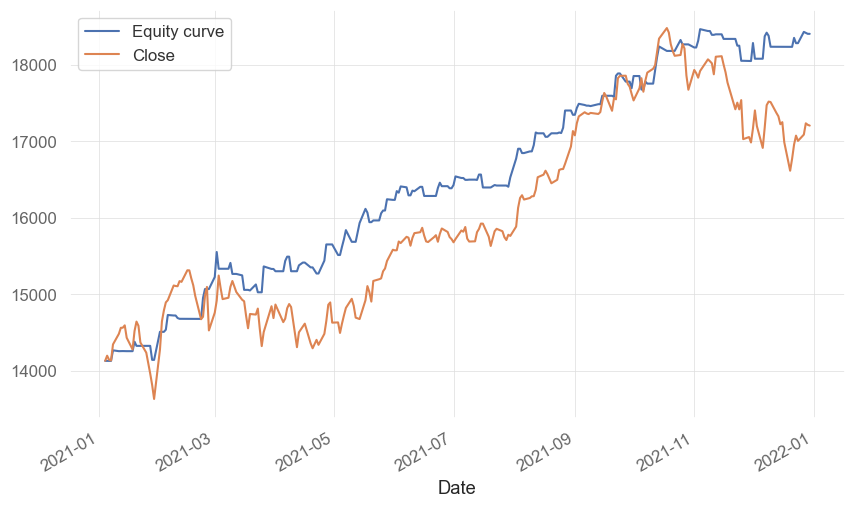

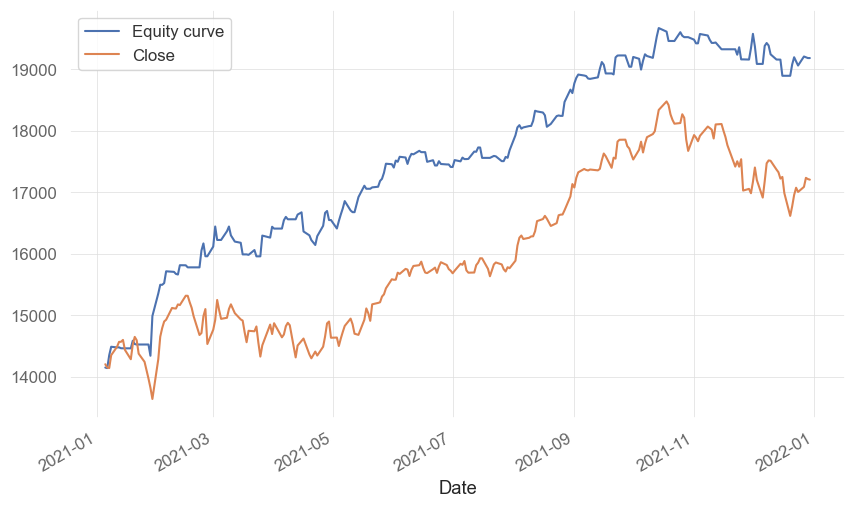

In [9]:
year = 2020

train = pd.read_excel(f'{year}.xlsx', parse_dates=True)
test = pd.read_excel(f'{year+1}.xlsx', parse_dates=True)
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)

linear = linear_regression(train, test)
logistic = logistic_regression(train, test) 

                           Strategy
-------------------------  ----------
Start Period               2021-01-05
End Period                 2021-12-30
Risk-Free Rate             0.0%
Time in Market             56.0%

Cumulative Return          30.21%
CAGR﹪                     20.36%

Sharpe                     3.13
Prob. Sharpe Ratio         99.97%
Smart Sharpe               2.99
Sortino                    6.22
Smart Sortino              5.94
Sortino/√2                 4.4
Smart Sortino/√2           4.2
Omega                      2.08

Max Drawdown               -3.38%
Longest DD Days            55
Volatility (ann.)          8.82%
Calmar                     6.02
Skew                       1.07
Kurtosis                   3.65

Expected Daily %           0.11%
Expected Monthly %         2.22%
Expected Yearly %          30.21%
Kelly Criterion            26.31%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.8%
Expected Shortfall (cVaR)  -0.8%

Max Consecutive Wins       3
Max

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-03-03,2021-03-23,2021-04-26,55,-3.382851,-3.228866
2,2021-11-08,2021-11-29,2021-12-30,53,-2.252121,-2.236955
3,2021-01-20,2021-01-28,2021-01-29,10,-1.649950,-0.377896
4,2021-09-27,2021-10-05,2021-10-11,15,-1.173379,-1.077764
5,2021-05-18,2021-05-19,2021-05-27,10,-1.077154,-0.938166


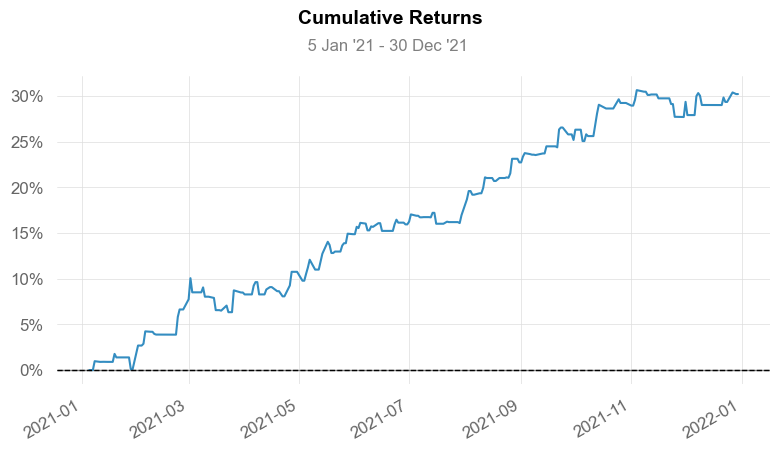

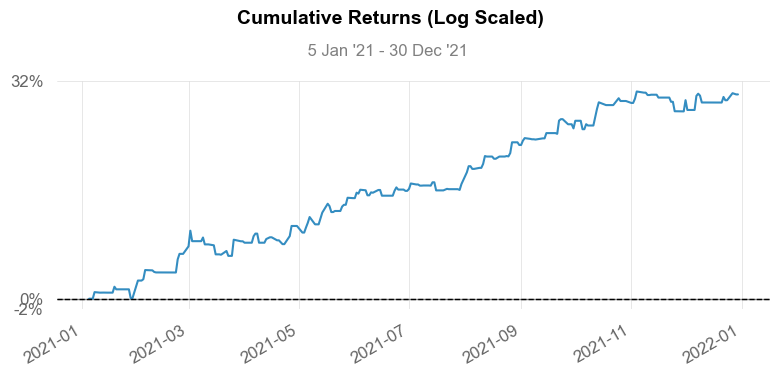

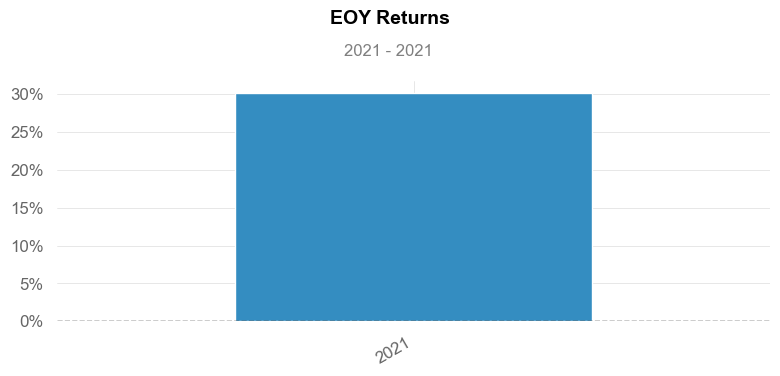

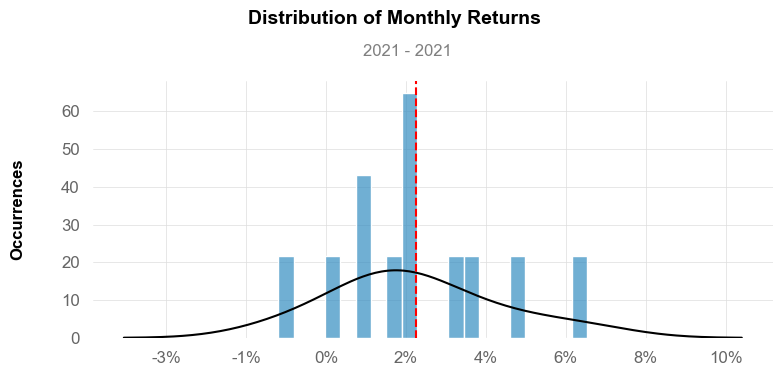

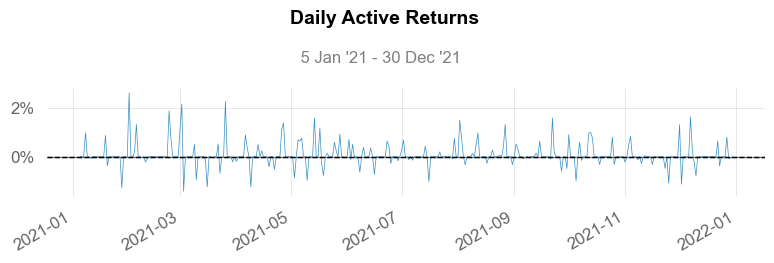

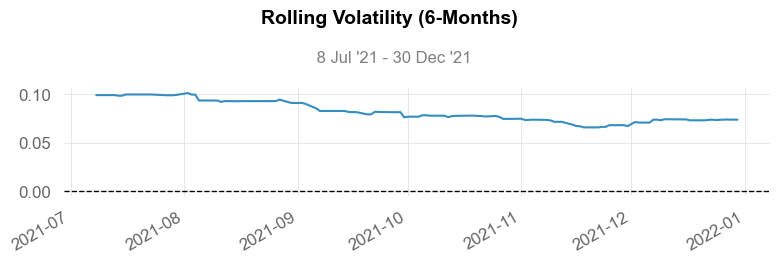

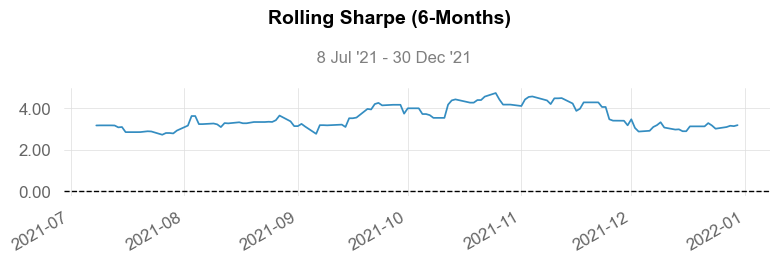

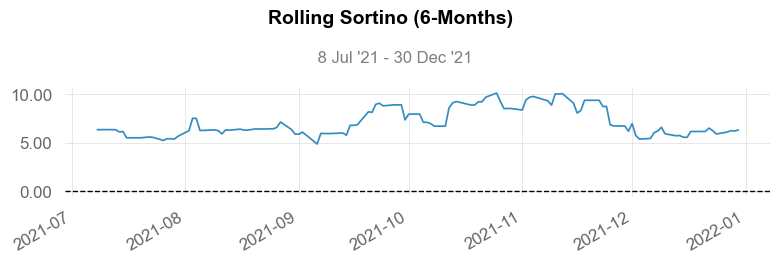

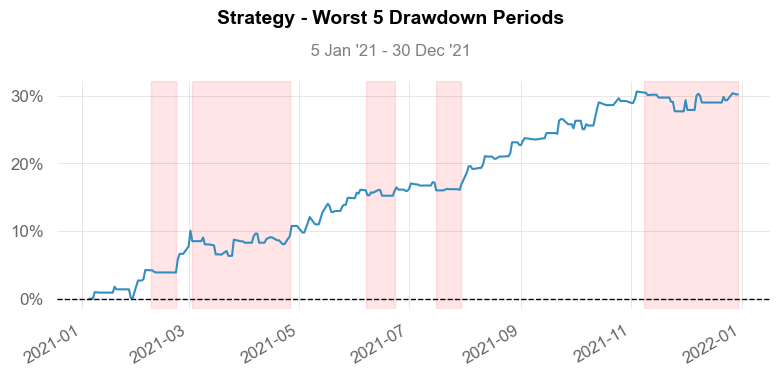

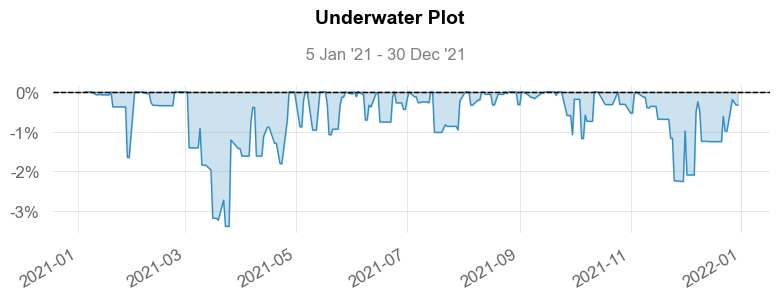

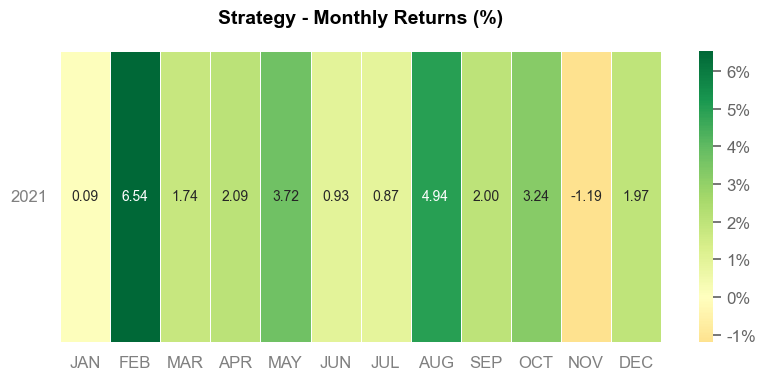

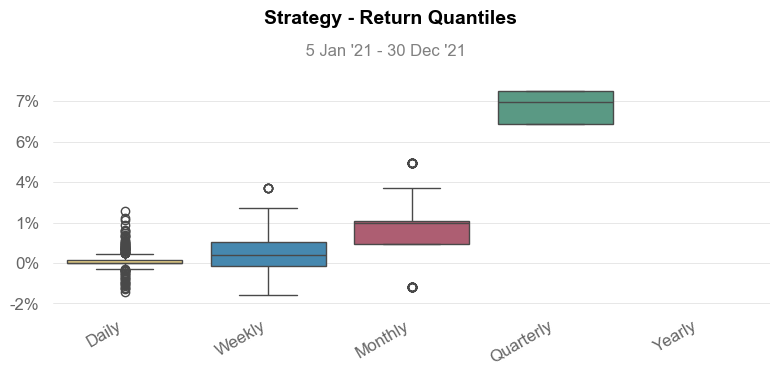

In [10]:
performance_analysis(linear) 

                           Strategy
-------------------------  ----------
Start Period               2021-01-06
End Period                 2021-12-30
Risk-Free Rate             0.0%
Time in Market             79.0%

Cumulative Return          35.61%
CAGR﹪                     23.92%

Sharpe                     2.97
Prob. Sharpe Ratio         99.94%
Smart Sharpe               2.59
Sortino                    5.77
Smart Sortino              5.04
Sortino/√2                 4.08
Smart Sortino/√2           3.56
Omega                      1.83

Max Drawdown               -3.95%
Longest DD Days            74
Volatility (ann.)          10.79%
Calmar                     6.06
Skew                       1.36
Kurtosis                   7.39

Expected Daily %           0.12%
Expected Monthly %         2.57%
Expected Yearly %          35.61%
Kelly Criterion            22.12%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.99%
Expected Shortfall (cVaR)  -0.99%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-10-18,2021-12-16,2021-12-30,74,-3.949124,-3.100687
2,2021-04-16,2021-04-22,2021-04-27,12,-3.187080,-2.708433
3,2021-03-03,2021-03-23,2021-04-05,34,-2.952294,-2.806626
4,2021-04-29,2021-05-03,2021-05-05,7,-1.708378,-0.981479
5,2021-01-20,2021-01-28,2021-01-28,9,-1.674987,-0.420376


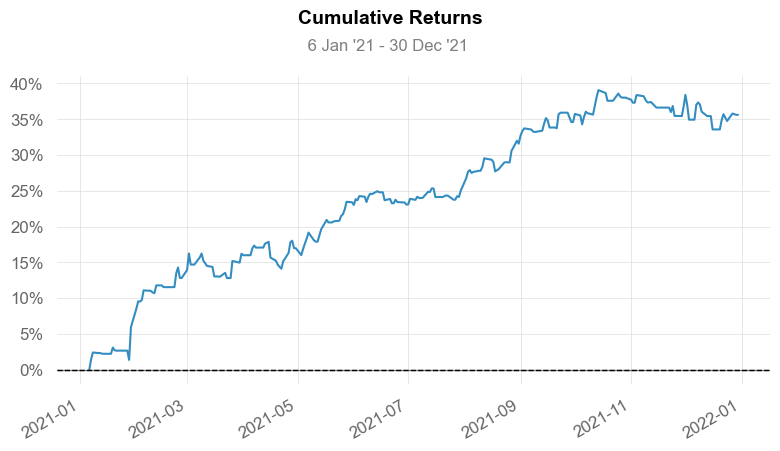

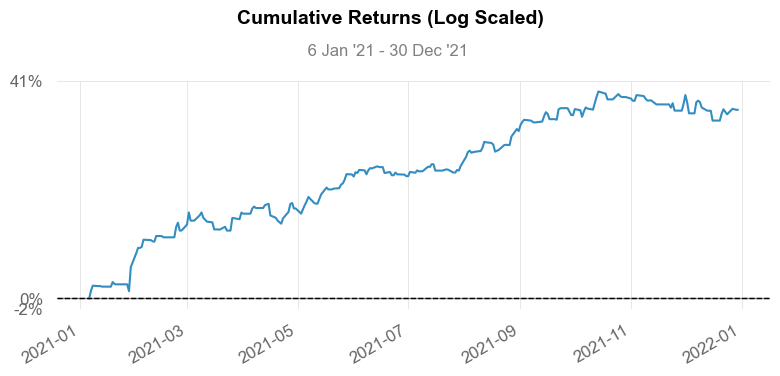

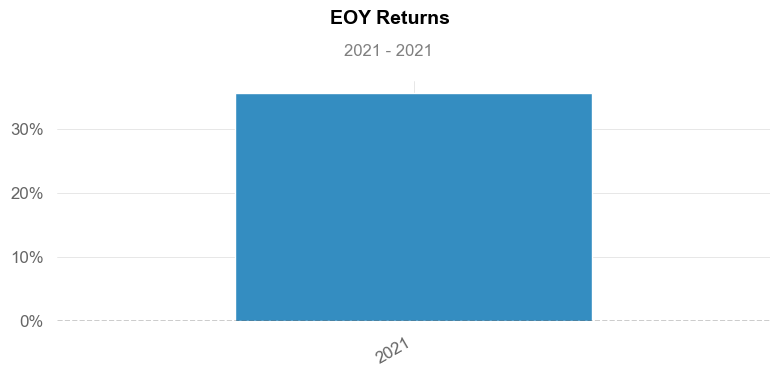

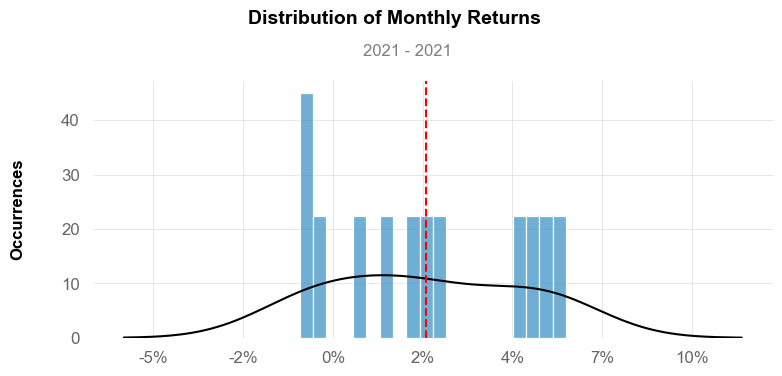

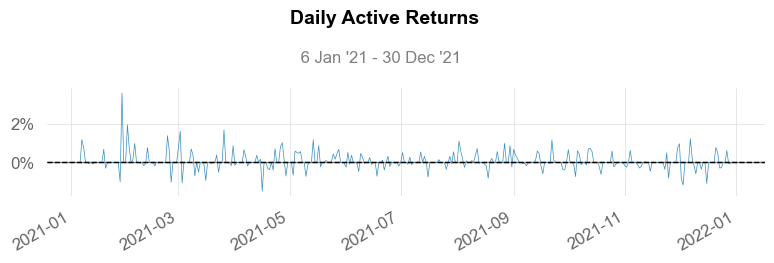

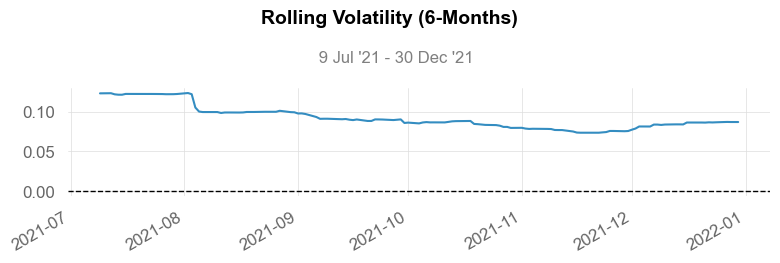

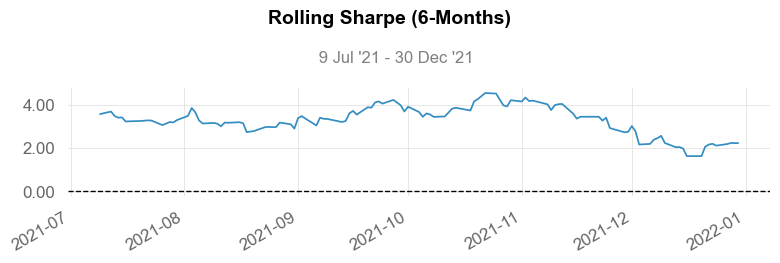

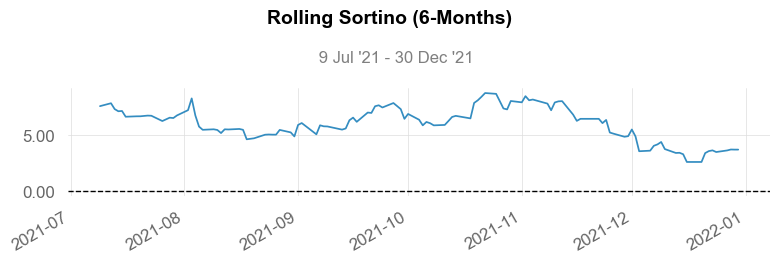

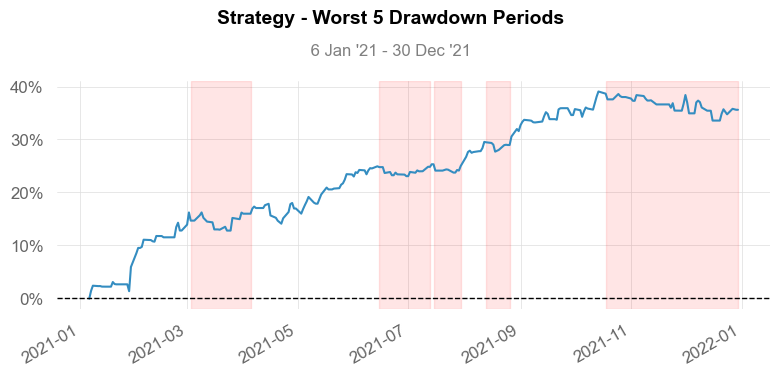

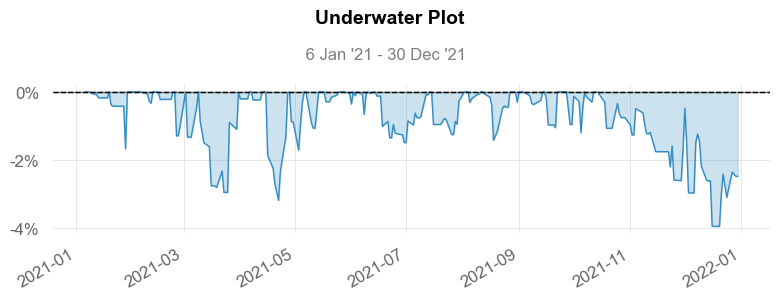

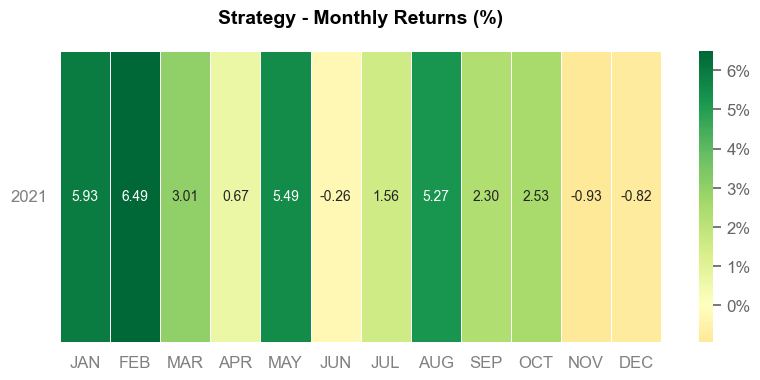

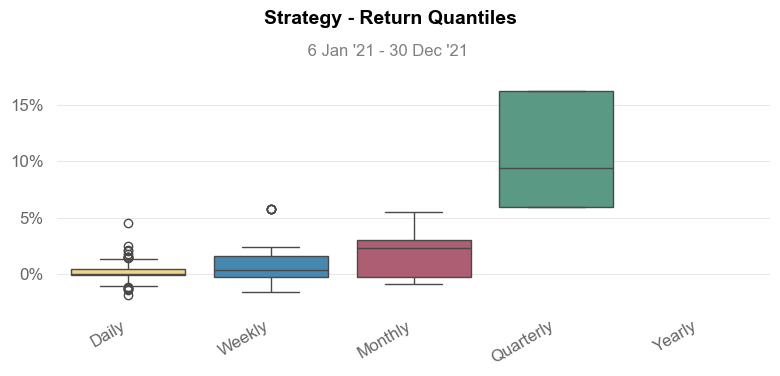

In [11]:
performance_analysis(logistic) 